In [7]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [8]:
#get migration patterns
flow_df = pd.read_csv('hcr_dat_border.csv')
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3', 'Country'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace(',', '')
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace('-', '0')
flow_df['border_crossings'] = flow_df['border_crossings'].str.strip().astype('int')
flow_df = flow_df.groupby(['date']).sum()
flow_df.head()

,border_crossings
date,
2022-02-24,65846
2022-02-25,90155
2022-02-26,131865
2022-02-27,154046
2022-02-28,149041


In [9]:
#get emotion data
df_emotion = pd.read_csv('../Indicators/Emotion/binary_predictions_2022.csv')
df_emotion.drop(columns=df_emotion.columns[0], inplace=True)
df_emotion['date'] = pd.to_datetime(df_emotion['date'], format='%Y-%m-%d')
df_emotion.head()

,date,city,tweet,predicted_emotion
0,2022-10-22,Хмельницький,RT @dw_ukrainian: Хмельницький залишився без с...,others
1,2022-10-22,Хмельницький,RT @dw_ukrainian: Хмельницький залишився без с...,others
2,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
3,2022-10-22,Хмельницький,Хмельницький після вранішніх вибухів опинився ...,sadness
4,2022-10-22,Хмельницький,RT @tsnua: Хмельницький після вранішніх вибухі...,sadness


In [10]:
#group by emotion count
df_emotion = df_emotion.groupby(['date', 'predicted_emotion']).count()
df_emotion.drop(columns=['city'], inplace=True)

In [11]:
merged_df = flow_df.merge(df_emotion, left_index=True, right_index=True, how='inner')
merged_df.head()

border_crossings  tweet
date       predicted_emotion                         
2022-02-24 joy                           65846      6
           others                        65846      6
           sadness                       65846      1
2022-02-25 anger                         90155     14
           fear                          90155      5

In [12]:
#reindex so all emotion/date combos are present
all_dates = pd.date_range(np.min(merged_df.index.get_level_values('date')), np.max(merged_df.index.get_level_values('date')))
all_emotions = list(set(merged_df.index.get_level_values('predicted_emotion')))
ind2 = pd.MultiIndex.from_product([all_dates,all_emotions], names = ['date','emotion'])
merged_df = merged_df.reindex(ind2, fill_value = 0) 
merged_df.index = merged_df.index.set_levels([pd.to_datetime(merged_df.index.levels[0]), merged_df.index.levels[1]])
merged_df.drop(columns=['border_crossings'], inplace=True)
merged_df.head()

tweet
date       emotion       
2022-02-24 fear         0
           sadness      1
           anger        0
           others       6
           joy          6

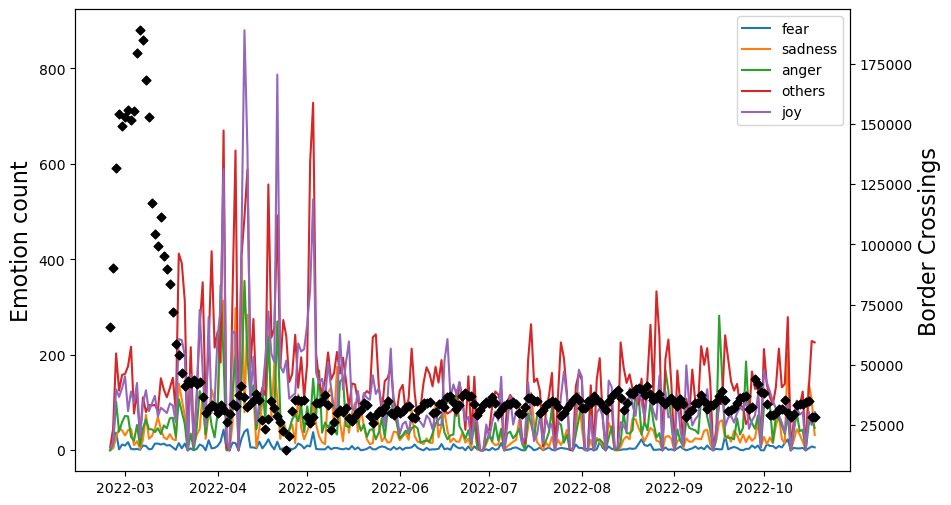

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
for r in all_emotions:
    ax.plot(merged_df.xs(r,level=1).loc[:,'tweet'], label = r)
ax2.scatter(flow_df.index.values, flow_df.border_crossings.values, color='black', marker='D', s=20)
ax.set_ylabel('Emotion count', fontsize=16)
ax2.set_ylabel('Border Crossings', fontsize=16)
ax.legend()

## Correlations for lead/lag with raw counts

In [80]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

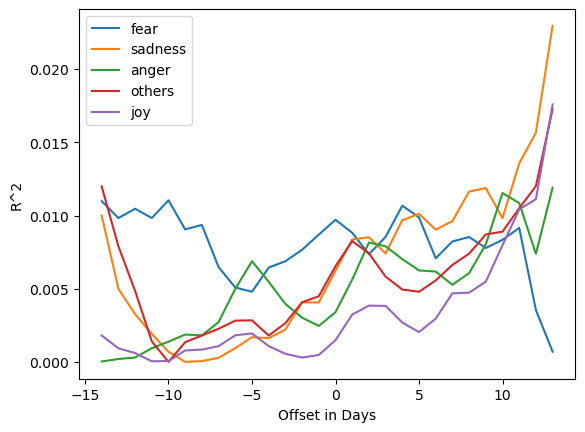

In [81]:
#graph all correlations from -2 weeks to +2 weeks -- highest two weeks out
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.xlabel('Offset in Days')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [82]:
offset_range = np.arange(0, 30)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

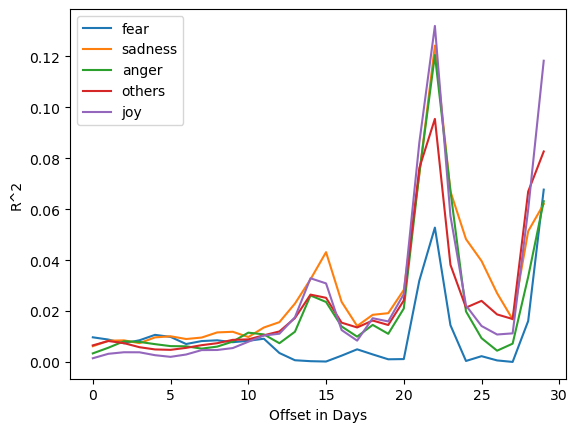

In [83]:
#graph all correlations to one month shift
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.xlabel('Offset in Days')
plt.ylabel('R^2')
plt.legend()
plt.show()

## Correlations for lead/lag with proportions

In [84]:
merged_df['proportion'] = merged_df.groupby(level=0).apply(lambda x: x/x.sum())['tweet'].values
merged_df.head()

tweet  proportion
date       emotion                   
2022-02-24 fear         0    0.000000
           sadness      1    0.076923
           anger        0    0.000000
           others       6    0.461538
           joy          6    0.461538

In [85]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'proportion'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

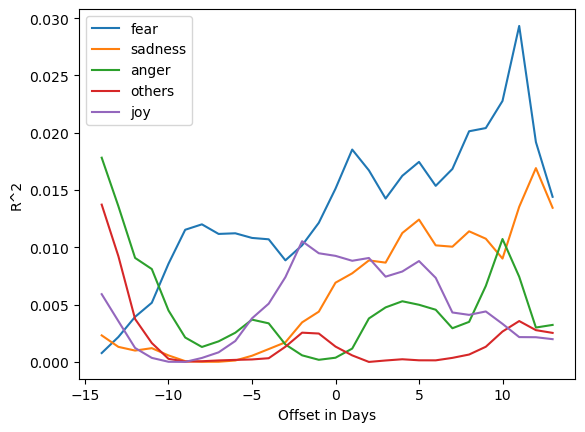

In [86]:
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.xlabel('Offset in Days')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [149]:
unstacked_prop = merged_df['proportion'].unstack(level=1)
correlations = pd.concat([unstacked_prop,flow_df['border_crossings']], axis=1).corr()['border_crossings']
print(correlations)

anger              -0.019190
fear                0.122962
joy                 0.096210
others             -0.036618
sadness            -0.083161
border_crossings    1.000000
Name: border_crossings, dtype: float64


## Correlation for lead/lag with difference from mean

In [92]:
merged_df['mean_diff'] = merged_df['tweet'] - merged_df.groupby(level=0).mean()['tweet']
merged_df.head()

tweet  proportion  mean_diff
date       emotion                              
2022-02-24 fear         0    0.000000       -2.6
           sadness      1    0.076923       -1.6
           anger        0    0.000000       -2.6
           others       6    0.461538        3.4
           joy          6    0.461538        3.4

In [99]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'mean_diff'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

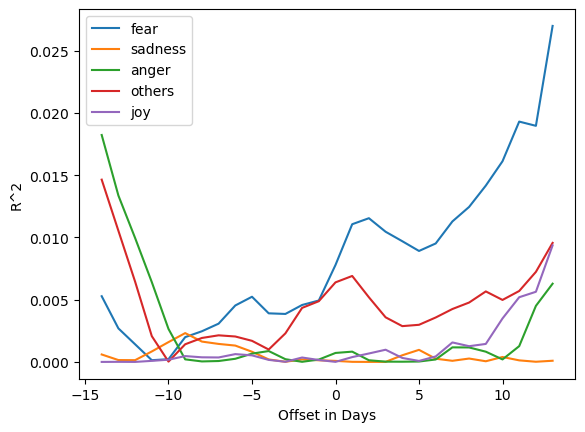

In [100]:
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.xlabel('Offset in Days')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [151]:
unstacked_mean = merged_df['mean_diff'].unstack(level=1)
correlations = pd.concat([unstacked_mean,flow_df['border_crossings']], axis=1).corr()['border_crossings']
print(correlations)

anger               0.026860
fear                0.088269
joy                -0.002300
others             -0.079953
sadness            -0.009174
border_crossings    1.000000
Name: border_crossings, dtype: float64
